In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings(action='ignore')

import matplotlib
import sklearn

In [0]:
train=pd.read_csv('train.csv', index_col=0)
test=pd.read_csv('test.csv',index_col=0)
submission = pd.read_csv('sample_submission.csv')

In [7]:
train

,rho,650_src,660_src,670_src,680_src,690_src,700_src,710_src,720_src,730_src,740_src,750_src,760_src,770_src,780_src,790_src,800_src,810_src,820_src,830_src,840_src,850_src,860_src,870_src,880_src,890_src,900_src,910_src,920_src,930_src,940_src,950_src,960_src,970_src,980_src,990_src,650_dst,660_dst,670_dst,680_dst,690_dst,700_dst,710_dst,720_dst,730_dst,740_dst,750_dst,760_dst,770_dst,780_dst,790_dst,800_dst,810_dst,820_dst,830_dst,840_dst,850_dst,860_dst,870_dst,880_dst,890_dst,900_dst,910_dst,920_dst,930_dst,940_dst,950_dst,960_dst,970_dst,980_dst,990_dst,hhb,hbo2,ca,na
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,25,0.37950,0.42993,0.52076,0.57166,0.67818,0.75476,0.83580,0.93623,0.96333,1.01541,0.99865,0.94373,0.84513,0.74023,0.68776,0.57697,0.51536,0.43508,0.36501,0.34935,0.30038,0.26992,0.23192,0.21998,0.19920,0.14493,0.13150,0.12442,0.10786,0.11984,0.09851,0.10965,0.07424,0.07777,0.05536,2.447758e-18,1.894578e-18,0.000000e+00,6.412913e-18,1.098559e-17,8.907142e-19,NaN,0.000000e+00,NaN,0.000000e+00,5.901745e-18,NaN,1.176812e-18,NaN,5.557492e-17,1.046498e-16,NaN,7.236748e-17,4.021610e-17,2.397489e-17,1.870153e-17,1.808920e-17,NaN,0.000000e+00,2.626216e-18,NaN,3.527371e-18,NaN,6.455564e-19,NaN,0.000000e+00,NaN,1.067504e-18,5.998949e-18,4.378513e-17,5.59,4.32,8.92,4.29
1,10,0.00000,0.00000,0.01813,0.00000,0.00000,0.01974,0.00321,0.00000,0.00000,0.01295,0.00000,0.01565,0.00000,0.00000,0.01285,0.01129,0.00359,0.00000,0.00000,0.00000,0.00000,0.00000,0.04466,0.10738,0.21646,0.41456,0.63716,0.84230,0.97480,0.99803,0.97146,0.87045,0.75330,0.63414,0.53699,0.000000e+00,0.000000e+00,0.000000e+00,1.995530e-10,1.025259e-10,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00,1.151021e-10,4.318673e-10,2.753933e-10,0.000000e+00,8.138830e-10,6.522110e-10,NaN,2.732232e-10,NaN,7.663267e-11,NaN,1.389496e-10,1.472282e-09,1.450463e-09,1.225321e-09,2.647633e-09,NaN,5.233480e-09,1.264238e-08,1.343132e-08,6.112685e-09,2.130547e-09,NaN,9.710091e-09,NaN,0.00,2.83,7.25,4.64
2,25,0.00000,0.03289,0.02416,0.03610,0.05843,0.09015,0.14944,0.18578,0.25584,0.30445,0.38962,0.50472,0.56934,0.67742,0.79720,0.87593,0.92783,0.99498,0.98682,0.98988,0.95101,0.89853,0.79813,0.68262,0.58043,0.46222,0.39113,0.27879,0.19070,0.16603,0.11617,0.06744,0.02343,0.03926,0.03136,1.677445e-19,3.763590e-20,NaN,0.000000e+00,NaN,NaN,8.981651e-19,1.944683e-19,8.126907e-19,2.183200e-19,3.349335e-19,NaN,0.000000e+00,2.630961e-18,NaN,0.000000e+00,9.912979e-18,1.112747e-17,NaN,NaN,NaN,1.260239e-19,NaN,0.000000e+00,3.876159e-18,4.629125e-18,1.409413e-18,3.237480e-18,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.329725e-18,NaN,10.64,3.00,8.40,5.16
3,10,0.27503,0.31281,0.32898,0.41041,0.46587,0.52769,0.64369,0.73562,0.79865,0.91482,0.95274,0.99391,1.00563,0.93165,0.84703,0.74997,0.67765,0.58432,0.50642,0.43087,0.35684,0.30786,0.27722,0.24119,0.20158,0.17876,0.15139,0.15656,0.13392,0.14247,0.10126,0.09928,0.09239,0.10523,0.06349,4.044975e-11,NaN,5.345363e-11,9.106886e-12,1.881458e-11,3.617201e-11,7.909656e-13,NaN,1.583839e-10,NaN,1.678049e-10,2.814419e-10,4.429321e-10,1.319956e-09,2.269806e-09,2.679164e-09,2.538200e-09,2.046841e-09,1.516820e-09,1.328007e-09,1.061359e-09,8.634016e-10,5.804951e-10,3.615067e-10,NaN,1.274876e-10,6.118947e-11,NaN,1.663888e-10,2.245998e-10,1.299511e-10,7.782625e-11,NaN,4.088921e-10,NaN,5.67,4.01,5.05,4.35
4,15,1.01521,1.00872,0.98930,0.98874,1.01773,1.01632,1.00009,0.98217,1.01564,1.00216,1.01190,1.00344,0.98365,1.01350,1.01649,0.98220,0.99091,0.99258,1.00175,0.98861,0.98270,1.00432,1.01434,1.01455,0.98861,0.98300,1.00616,0.99045,1.01321,1.01559,1.01072,0.99439,0.98597,0.99889,1.01412,4.784751e-14,NaN,0.000000e+00,1.153089e-13,0.000000e+00,0.000000e+00,1.056991e-13,0.000000e+00,0.000000e+00,2.666663e-14,1.493071e-14,NaN,0.000000e+00,1.200730e-13,2.648249e-13,NaN,4.392331e-13,2.831191e-13,4.557059e-13,1.326038e-13,1.864796e-13,1.419359e-13,1.765559e-13,1.593789e-13,NaN,0.000000e+00,NaN,1.537619e-14,4.9

In [8]:
test

,rho,650_src,660_src,670_src,680_src,690_src,700_src,710_src,720_src,730_src,740_src,750_src,760_src,770_src,780_src,790_src,800_src,810_src,820_src,830_src,840_src,850_src,860_src,870_src,880_src,890_src,900_src,910_src,920_src,930_src,940_src,950_src,960_src,970_src,980_src,990_src,650_dst,660_dst,670_dst,680_dst,690_dst,700_dst,710_dst,720_dst,730_dst,740_dst,750_dst,760_dst,770_dst,780_dst,790_dst,800_dst,810_dst,820_dst,830_dst,840_dst,850_dst,860_dst,870_dst,880_dst,890_dst,900_dst,910_dst,920_dst,930_dst,940_dst,950_dst,960_dst,970_dst,980_dst,990_dst
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10000,15,0.15406,0.23275,0.30977,0.42949,0.51264,0.62558,0.74340,0.85418,0.90815,0.95973,0.98963,1.00633,0.93637,0.90501,0.80721,0.67517,0.56850,0.47049,0.37681,0.28318,0.20309,0.14741,0.10475,0.05867,0.06330,0.02841,0.01290,0.00132,0.00000,0.00000,0.01904,0.00000,0.01952,0.00000,0.01285,0.000000e+00,NaN,7.028318e-15,NaN,NaN,2.191340e-14,2.204989e-14,0.000000e+00,0.000000e+00,1.306867e-15,NaN,7.064663e-14,9.958556e-14,2.511703e-13,8.145713e-13,NaN,NaN,7.970892e-13,NaN,2.803227e-13,1.466433e-13,NaN,5.927522e-14,2.185519e-14,NaN,0.000000e+00,0.000000e+00,1.432248e-14,0.000000e+00,0.000000e+00,6.332117e-15,1.429966e-14,0.000000e+00,NaN,7.320236e-14
10001,15,0.48552,0.56939,0.67575,0.79089,0.85114,0.92581,0.98071,0.98177,0.98678,0.95641,0.87884,0.80476,0.71898,0.60703,0.50844,0.43139,0.34349,0.26715,0.17880,0.15375,0.09830,0.06955,0.03164,0.03791,0.03539,0.01144,0.00703,0.00096,0.01406,0.00000,0.00223,0.01188,0.00000,0.00910,0.00201,NaN,3.744801e-13,1.190392e-14,9.131521e-13,1.796724e-14,1.081485e-14,0.000000e+00,0.000000e+00,NaN,1.810959e-14,8.088957e-13,1.425479e-12,NaN,1.757695e-12,1.816649e-12,4.615024e-12,3.979741e-12,NaN,NaN,1.089426e-12,NaN,4.849117e-13,3.003396e-13,3.783172e-14,3.432298e-14,1.036013e-13,NaN,2.830975e-14,1.114337e-13,4.825731e-14,NaN,2.282485e-14,7.348414e-14,1.259055e-13,2.349874e-13
10002,10,0.46883,0.56085,0.62442,0.73172,0.81724,0.91517,0.94801,0.99108,1.01261,0.96075,0.88151,0.80859,0.73041,0.62614,0.52916,0.46809,0.40735,0.35620,0.32311,0.27406,0.23611,0.19970,0.18395,0.17000,0.14073,0.13508,0.14524,0.10918,0.10280,0.10387,0.09468,0.06623,0.08721,0.06559,0.06880,1.732202e-12,1.827363e-11,1.332869e-11,2.641682e-12,3.498661e-12,1.466659e-11,2.981251e-11,2.764069e-11,0.000000e+00,3.423157e-12,4.370910e-11,1.748554e-11,3.404800e-11,8.673897e-11,1.875337e-10,2.337955e-10,2.074666e-10,1.742070e-10,NaN,9.815230e-11,NaN,6.323332e-11,5.504236e-11,3.523197e-11,1.264857e-11,NaN,NaN,NaN,NaN,1.569208e-11,6.242378e-12,NaN,1.219010e-11,NaN,NaN
10003,10,0.06905,0.07517,0.10226,0.14905,0.16182,0.19659,0.26085,0.36753,0.51432,0.70530,0.92052,1.00194,0.92491,0.70450,0.52336,0.37686,0.26057,0.22032,0.14476,0.11934,0.09141,0.09077,0.08446,0.07500,0.06403,0.04793,0.03783,0.04006,0.02746,0.04642,0.00630,0.01501,0.01071,0.03310,0.01281,0.000000e+00,NaN,0.000000e+00,2.713471e-12,6.567726e-12,2.069053e-12,3.467277e-12,0.000000e+00,1.275280e-11,NaN,1.257803e-11,1.179720e-11,1.207228e-10,2.049794e-10,3.930583e-10,4.045076e-10,2.890125e-10,NaN,NaN,9.696636e-11,7.976577e-11,6.720191e-11,5.054397e-11,3.088529e-11,7.378972e-12,1.651177e-11,7.282747e-12,5.010879e-12,NaN,1.571023e-11,0.000000e+00,0.000000e+00,3.304247e-12,4.106134e-11,NaN
10004,25,0.00253,0.00757,0.01649,0.00128,0.00000,0.00000,0.00105,0.01975,0.00000,0.00526,0.00000,0.00111,0.00000,0.00000,0.00651,0.00000,0.00544,0.04805,0.05783,0.09923,0.17500,0.26861,0.33419,0.47074,0.58215,0.72828,0.83838,0.92615,0.96783,0.99902,1.00555,0.95138,0.91243,0.85656,0.76263,0.000000e+00,4.030214e-17,NaN,2.500016e-17,0.000000e+00,0.000000e+00,0.000000e+00,3.969590e-17,1.461565e-18,NaN,9.746350e-18,1.664548e-17,1.931133e-17,2.261459e-17,2.263433e-18,2.424745e-17,0.000000e+00,1.911587e-17,0.000000e+00,1.471418e-17,1.964881e-17,NaN,5.723552e-17,4.577178e-17,4.128159e-17,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.732057e-17,4.110605e-17,0.000000e+00,0.00

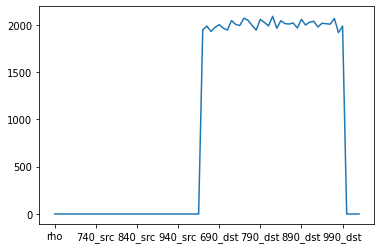

In [9]:
train.isna().sum().plot()

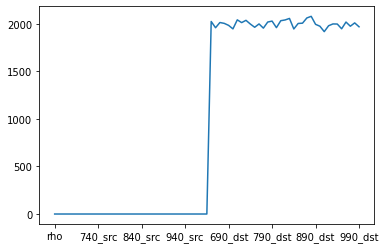

In [10]:
 test.isna().sum().plot()

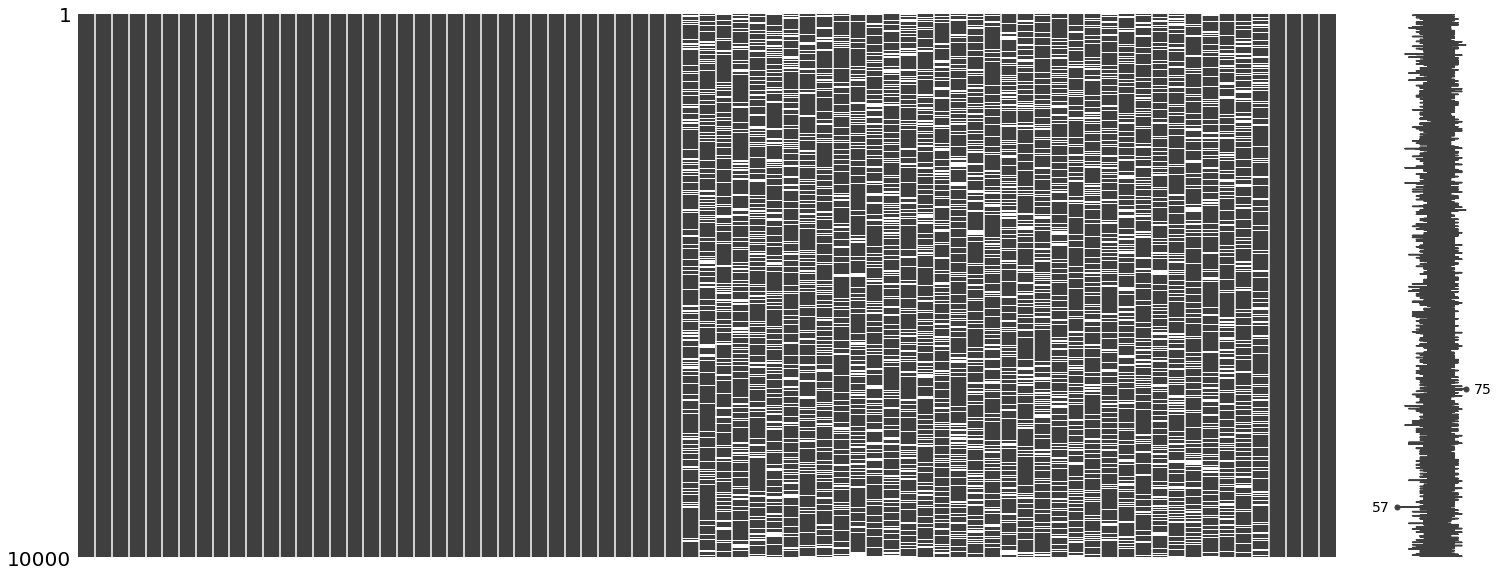

In [11]:
import missingno as msno

msno.matrix(train)

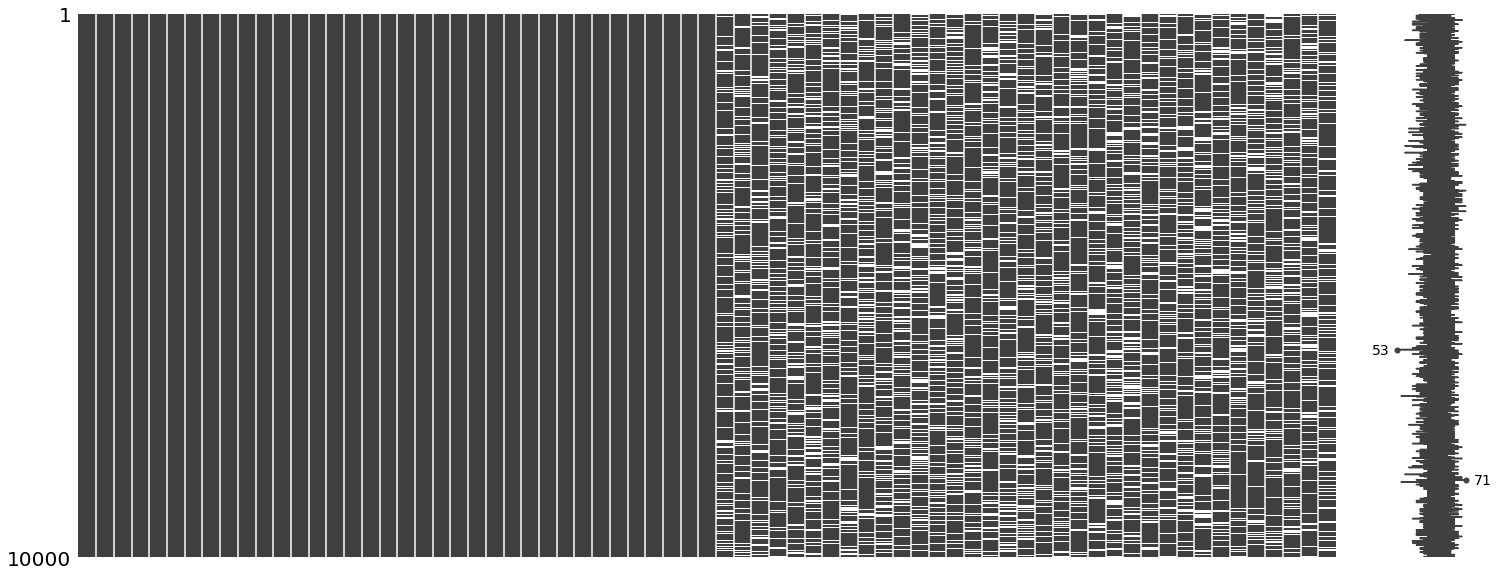

In [12]:
msno.matrix(test)

In [13]:
train.isnull().sum()[train.isnull().sum().values > 0]

650_dst    1948
660_dst    1988
670_dst    1931
680_dst    1975
690_dst    2003
700_dst    1966
710_dst    1946
720_dst    2046
730_dst    2006
740_dst    1993
750_dst    2071
760_dst    2050
770_dst    1994
780_dst    1945
790_dst    2059
800_dst    2026
810_dst    1990
820_dst    2091
830_dst    1965
840_dst    2045
850_dst    2014
860_dst    2010
870_dst    2020
880_dst    1968
890_dst    2059
900_dst    1999
910_dst    2030
920_dst    2038
930_dst    1978
940_dst    2018
950_dst    2013
960_dst    2008
970_dst    2069
980_dst    1919
990_dst    1987
dtype: int64

In [14]:
test.isnull().sum()[test.isnull().sum().values > 0]

650_dst    2026
660_dst    1960
670_dst    2015
680_dst    2006
690_dst    1985
700_dst    1948
710_dst    2043
720_dst    2014
730_dst    2038
740_dst    1999
750_dst    1965
760_dst    2000
770_dst    1956
780_dst    2020
790_dst    2030
800_dst    1961
810_dst    2034
820_dst    2042
830_dst    2058
840_dst    1947
850_dst    2005
860_dst    2008
870_dst    2063
880_dst    2080
890_dst    1996
900_dst    1976
910_dst    1919
920_dst    1981
930_dst    2000
940_dst    1999
950_dst    1949
960_dst    2020
970_dst    1976
980_dst    2011
990_dst    1970
dtype: int64

In [15]:
#--> train,test 데이터에서 결측치가 존재하는 행들이 동일해보인다. 실제로 같은지 확인한다
print(train.isnull().sum()[train.isnull().sum().values > 0].index)

Index(['650_dst', '660_dst', '670_dst', '680_dst', '690_dst', '700_dst',
       '710_dst', '720_dst', '730_dst', '740_dst', '750_dst', '760_dst',
       '770_dst', '780_dst', '790_dst', '800_dst', '810_dst', '820_dst',
       '830_dst', '840_dst', '850_dst', '860_dst', '870_dst', '880_dst',
       '890_dst', '900_dst', '910_dst', '920_dst', '930_dst', '940_dst',
       '950_dst', '960_dst', '970_dst', '980_dst', '990_dst'],
      dtype='object')


## 1.2 데이터의 의미 파악

광원 스펙트럼과 측정 스펙트럼값에 어떤 차이가 있는지 확인. 광원과 측정 스펙트럼 데이터를 나눠 시각화하고 데이터의 모양을 비교.

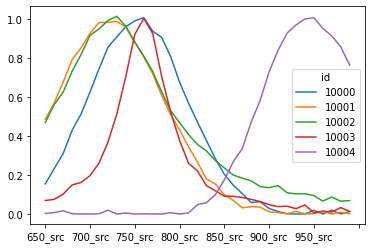

In [16]:
# 광원 스펙트럼

test.filter(regex='_src$',axis=1).head().T.plot()

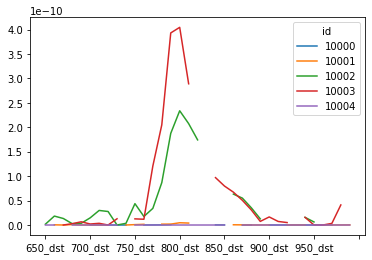

In [17]:
# 측정 스펙트럼

test.filter(regex='_dst$',axis=1).head().T.plot()

#--> 광원(src) 값과 달리 측정(dst) 데이터는 인위적인 끊김이 발견된다. 
# 정확한 기계학습을 위해서 끊어진 값들을 연결해줘야 한다.

### 2.1. 결측치 보간
- 스펙트럼은 650 ~ 950 nm 까지 곡선을 그려야 한다. 따라서 보간을 해줘야 한다.

- 먼저 dst 데이터만 따로 테이블을 만든다.

In [18]:
import numpy as np

train_dst = train.filter(regex='_dst$', axis=1).replace(0, np.NaN) # dst 데이터만 따로 뺀다.
test_dst = test.filter(regex='_dst$', axis=1).replace(0, np.NaN) # 보간을 하기위해 결측값을 삭제한다.
test_dst

,650_dst,660_dst,670_dst,680_dst,690_dst,700_dst,710_dst,720_dst,730_dst,740_dst,750_dst,760_dst,770_dst,780_dst,790_dst,800_dst,810_dst,820_dst,830_dst,840_dst,850_dst,860_dst,870_dst,880_dst,890_dst,900_dst,910_dst,920_dst,930_dst,940_dst,950_dst,960_dst,970_dst,980_dst,990_dst
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10000,NaN,NaN,7.028318e-15,NaN,NaN,2.191340e-14,2.204989e-14,NaN,NaN,1.306867e-15,NaN,7.064663e-14,9.958556e-14,2.511703e-13,8.145713e-13,NaN,NaN,7.970892e-13,NaN,2.803227e-13,1.466433e-13,NaN,5.927522e-14,2.185519e-14,NaN,NaN,NaN,1.432248e-14,NaN,NaN,6.332117e-15,1.429966e-14,NaN,NaN,7.320236e-14
10001,NaN,3.744801e-13,1.190392e-14,9.131521e-13,1.796724e-14,1.081485e-14,NaN,NaN,NaN,1.810959e-14,8.088957e-13,1.425479e-12,NaN,1.757695e-12,1.816649e-12,4.615024e-12,3.979741e-12,NaN,NaN,1.089426e-12,NaN,4.849117e-13,3.003396e-13,3.783172e-14,3.432298e-14,1.036013e-13,NaN,2.830975e-14,1.114337e-13,4.825731e-14,NaN,2.282485e-14,7.348414e-14,1.259055e-13,2.349874e-13
10002,1.732202e-12,1.827363e-11,1.332869e-11,2.641682e-12,3.498661e-12,1.466659e-11,2.981251e-11,2.764069e-11,NaN,3.423157e-12,4.370910e-11,1.748554e-11,3.404800e-11,8.673897e-11,1.875337e-10,2.337955e-10,2.074666e-10,1.742070e-10,NaN,9.815230e-11,NaN,6.323332e-11,5.504236e-11,3.523197e-11,1.264857e-11,NaN,NaN,NaN,NaN,1.569208e-11,6.242378e-12,NaN,1.219010e-11,NaN,NaN
10003,NaN,NaN,NaN,2.713471e-12,6.567726e-12,2.069053e-12,3.467277e-12,NaN,1.275280e-11,NaN,1.257803e-11,1.179720e-11,1.207228e-10,2.049794e-10,3.930583e-10,4.045076e-10,2.890125e-10,NaN,NaN,9.696636e-11,7.976577e-11,6.720191e-11,5.054397e-11,3.088529e-11,7.378972e-12,1.651177e-11,7.282747e-12,5.010879e-12,NaN,1.571023e-11,NaN,NaN,3.304247e-12,4.106134e-11,NaN
10004,NaN,4.030214e-17,NaN,2.500016e-17,NaN,NaN,NaN,3.969590e-17,1.461565e-18,NaN,9.746350e-18,1.664548e-17,1.931133e-17,2.261459e-17,2.263433e-18,2.424745e-17,NaN,1.911587e-17,NaN,1.471418e-17,1.964881e-17,NaN,5.723552e-17,4.577178e-17,4.128159e-17,NaN,NaN,NaN,NaN,3.732057e-17,4.110605e-17,NaN,NaN,1.910775e-16,2.215673e-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,NaN,1.059879e-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.775412e-14,5.283407e-13,1.361983e-12,2.916243e-12,NaN,3.292114e-12,2.630171e-12,2.554917e-12,2.633107e-12,3.173367e-12,3.178538e-12,1.462668e-12,2.786613e-13,7.889599e-13,NaN,4.903209e-13,1.365078e-12,7.929664e-13,NaN,NaN,1.472213e-13,1.479745e-12,5.391520e-12
19996,NaN,NaN,5.283427e-19,3.519532e-19,NaN,NaN,NaN,NaN,4.359929e-18,NaN,NaN,NaN,NaN,1.372321e-17,NaN,2.328368e-19,2.321802e-17,1.495695e-17,1.998833e-17,2.541768e-17,1.638928e-17,NaN,NaN,2.354055e-18,7.622563e-18,1.240848e-17,6.258180e-18,8.693704e-20,NaN,4.514449e-18,NaN,9.128300e-19,NaN,3.928314e-18,2.586781e-17
19997,1.452606e-15,4.033172e-15,2.832304e-15,NaN,NaN,NaN,NaN,2.593115e-13,1.187968e-13,NaN,NaN,2.575729e-15,8.142446e-15,NaN,2.591451e-13,2.291236e-13,2.978639e-14,NaN,8.139881e-14,NaN,6.736772e-14,NaN,1.205356e-15,4.468513e-15,2.263188e-15,NaN,NaN,NaN,2.610282e-14,7.789652e-15,NaN,1.271388e-15,1.436617e-15,NaN,1.743751e-13


In [19]:
train_dst = train_dst.interpolate(methods='linear', axis=1)
test_dst = test_dst.interpolate(methods='linear', axis=1)

# 스팩트럼 데이터에서 보간이 되지 않은 값은 0으로 일괄 처리한다.
train_dst.fillna(0, inplace=True) 
test_dst.fillna(0, inplace=True)
test_dst.head(1)

,650_dst,660_dst,670_dst,680_dst,690_dst,700_dst,710_dst,720_dst,730_dst,740_dst,750_dst,760_dst,770_dst,780_dst,790_dst,800_dst,810_dst,820_dst,830_dst,840_dst,850_dst,860_dst,870_dst,880_dst,890_dst,900_dst,910_dst,920_dst,930_dst,940_dst,950_dst,960_dst,970_dst,980_dst,990_dst
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10000,0.0,0.0,7.028318e-15,1.199001e-14,1.695171e-14,2.191340e-14,2.204989e-14,1.513555e-14,8.221207e-15,1.306867e-15,3.597675e-14,7.064663e-14,9.958556e-14,2.511703e-13,8.145713e-13,8.087439e-13,8.029166e-13,7.970892e-13,5.387060e-13,2.803227e-13,1.466433e-13,1.029592e-13,5.927522e-14,2.185519e-14,1.997201e-14,1.808883e-14,1.620565e-14,1.432248e-14,1.165902e-14,8.995570e-15,6.332117e-15,1.429966e-14,3.393389e-14,5.356813e-14,7.320236e-14


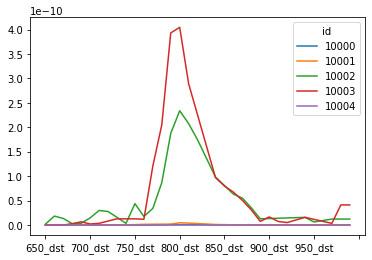

In [20]:
test_dst.head().T.plot()

In [0]:
train.update(train_dst) # 보간한 데이터를 기존 데이터프레임에 업데이트 한다.
test.update(test_dst)

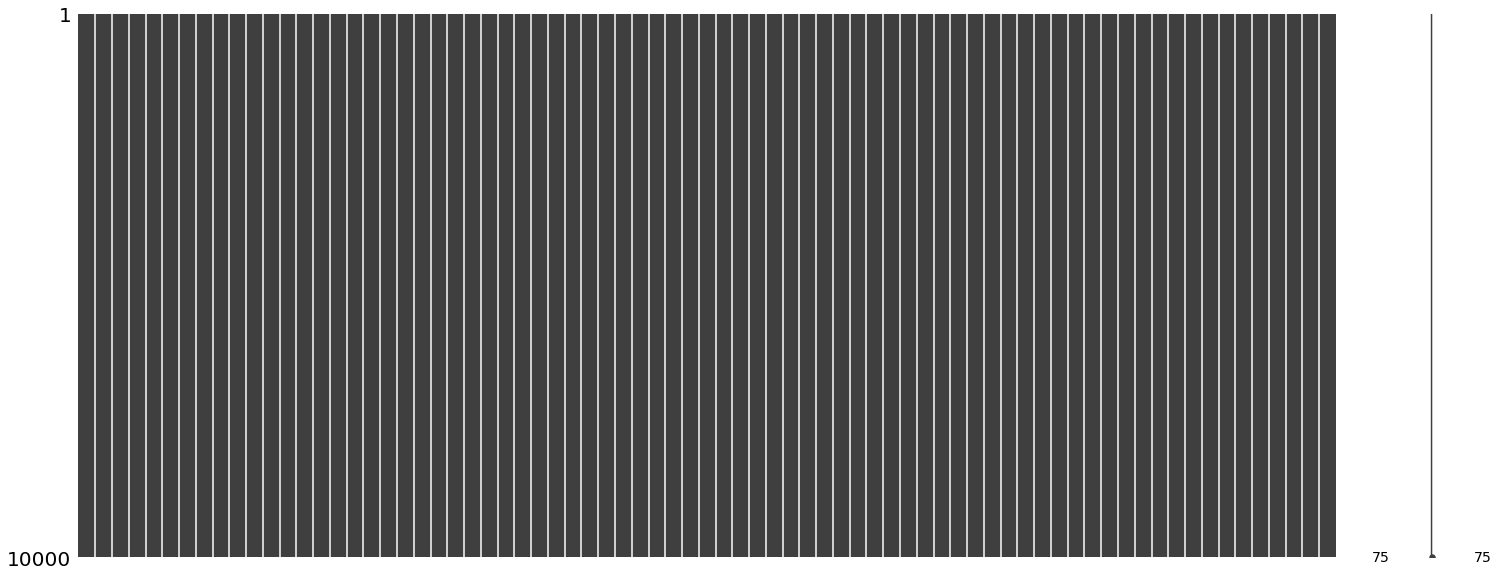

In [22]:
msno.matrix(train)

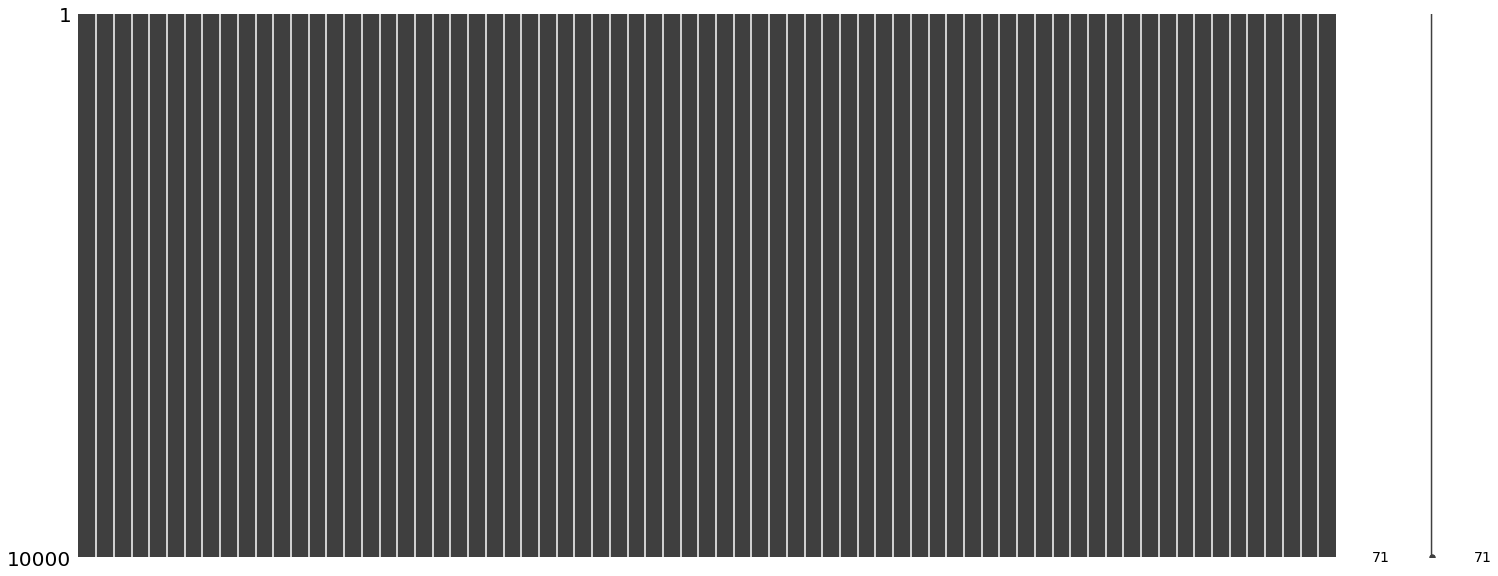

In [23]:
msno.matrix(test)

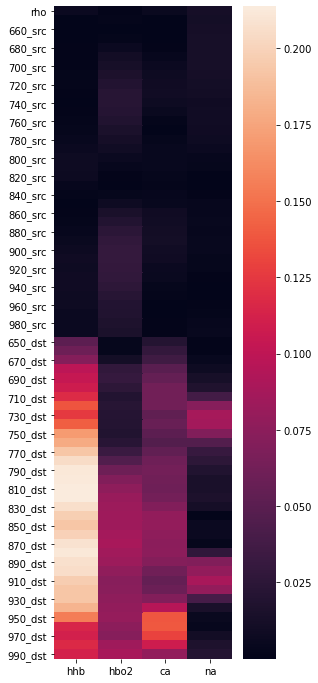

In [24]:
plt.figure(figsize=(4,12))
sns.heatmap(train.corr().loc['rho':'990_dst', 'hhb':].abs())

In [25]:
x_train = train.loc[:, '650_dst':'990_dst']
y_train = train.loc[:, 'hhb':'na']
x_train.shape, y_train.shape

((10000, 35), (10000, 4))

In [26]:
x_train.isna().sum()

650_dst    0
660_dst    0
670_dst    0
680_dst    0
690_dst    0
700_dst    0
710_dst    0
720_dst    0
730_dst    0
740_dst    0
750_dst    0
760_dst    0
770_dst    0
780_dst    0
790_dst    0
800_dst    0
810_dst    0
820_dst    0
830_dst    0
840_dst    0
850_dst    0
860_dst    0
870_dst    0
880_dst    0
890_dst    0
900_dst    0
910_dst    0
920_dst    0
930_dst    0
940_dst    0
950_dst    0
960_dst    0
970_dst    0
980_dst    0
990_dst    0
dtype: int64

In [27]:
test=test.loc[:, '650_dst':'990_dst']
test

,650_dst,660_dst,670_dst,680_dst,690_dst,700_dst,710_dst,720_dst,730_dst,740_dst,750_dst,760_dst,770_dst,780_dst,790_dst,800_dst,810_dst,820_dst,830_dst,840_dst,850_dst,860_dst,870_dst,880_dst,890_dst,900_dst,910_dst,920_dst,930_dst,940_dst,950_dst,960_dst,970_dst,980_dst,990_dst
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10000,0.000000e+00,0.000000e+00,7.028318e-15,1.199001e-14,1.695171e-14,2.191340e-14,2.204989e-14,1.513555e-14,8.221207e-15,1.306867e-15,3.597675e-14,7.064663e-14,9.958556e-14,2.511703e-13,8.145713e-13,8.087439e-13,8.029166e-13,7.970892e-13,5.387060e-13,2.803227e-13,1.466433e-13,1.029592e-13,5.927522e-14,2.185519e-14,1.997201e-14,1.808883e-14,1.620565e-14,1.432248e-14,1.165902e-14,8.995570e-15,6.332117e-15,1.429966e-14,3.393389e-14,5.356813e-14,7.320236e-14
10001,0.000000e+00,3.744801e-13,1.190392e-14,9.131521e-13,1.796724e-14,1.081485e-14,1.263854e-14,1.446222e-14,1.628590e-14,1.810959e-14,8.088957e-13,1.425479e-12,1.591587e-12,1.757695e-12,1.816649e-12,4.615024e-12,3.979741e-12,3.016303e-12,2.052864e-12,1.089426e-12,7.871688e-13,4.849117e-13,3.003396e-13,3.783172e-14,3.432298e-14,1.036013e-13,6.595554e-14,2.830975e-14,1.114337e-13,4.825731e-14,3.554108e-14,2.282485e-14,7.348414e-14,1.259055e-13,2.349874e-13
10002,1.732202e-12,1.827363e-11,1.332869e-11,2.641682e-12,3.498661e-12,1.466659e-11,2.981251e-11,2.764069e-11,1.553192e-11,3.423157e-12,4.370910e-11,1.748554e-11,3.404800e-11,8.673897e-11,1.875337e-10,2.337955e-10,2.074666e-10,1.742070e-10,1.361796e-10,9.815230e-11,8.069281e-11,6.323332e-11,5.504236e-11,3.523197e-11,1.264857e-11,1.325728e-11,1.386598e-11,1.447468e-11,1.508338e-11,1.569208e-11,6.242378e-12,9.216241e-12,1.219010e-11,1.219010e-11,1.219010e-11
10003,0.000000e+00,0.000000e+00,0.000000e+00,2.713471e-12,6.567726e-12,2.069053e-12,3.467277e-12,8.110039e-12,1.275280e-11,1.266541e-11,1.257803e-11,1.179720e-11,1.207228e-10,2.049794e-10,3.930583e-10,4.045076e-10,2.890125e-10,2.249971e-10,1.609818e-10,9.696636e-11,7.976577e-11,6.720191e-11,5.054397e-11,3.088529e-11,7.378972e-12,1.651177e-11,7.282747e-12,5.010879e-12,1.036055e-11,1.571023e-11,1.157490e-11,7.439573e-12,3.304247e-12,4.106134e-11,4.106134e-11
10004,0.000000e+00,4.030214e-17,3.265115e-17,2.500016e-17,2.867409e-17,3.234803e-17,3.602197e-17,3.969590e-17,1.461565e-18,5.603958e-18,9.746350e-18,1.664548e-17,1.931133e-17,2.261459e-17,2.263433e-18,2.424745e-17,2.168166e-17,1.911587e-17,1.691502e-17,1.471418e-17,1.964881e-17,3.844217e-17,5.723552e-17,4.577178e-17,4.128159e-17,4.048939e-17,3.969718e-17,3.890498e-17,3.811277e-17,3.732057e-17,4.110605e-17,9.109653e-17,1.410870e-16,1.910775e-16,2.215673e-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.000000e+00,1.059879e-13,1.043303e-13,1.026726e-13,1.010150e-13,9.935742e-14,9.769980e-14,9.604219e-14,9.438457e-14,9.272696e-14,9.106935e-14,8.941173e-14,8.775412e-14,5.283407e-13,1.361983e-12,2.916243e-12,3.104179e-12,3.292114e-12,2.630171e-12,2.554917e-12,2.633107e-12,3.173367e-12,3.178538e-12,1.462668e-12,2.786613e-13,7.889599e-13,6.396404e-13,4.903209e-13,1.365078e-12,7.929664e-13,5.777180e-13,3.624696e-13,1.472213e-13,1.479745e-12,5.391520e-12
19996,0.000000e+00,0.000000e+00,5.283427e-19,3.519532e-19,1.153548e-18,1.955144e-18,2.756739e-18,3.558334e-18,4.359929e-18,6.232585e-18,8.105241e-18,9.977896e-18,1.185055e-17,1.372321e-17,6.978022e-18,2.328368e-19,2.321802e-17,1.495695e-17,1.998833e-17,2.541768e-17,1.638928e-17,1.171087e-17,7.032464e-18,2.354055e-18,7.622563e-18,1.240848e-17,6.258180e-18,8.693704e-20,2.300693e-18,4.514449e-18,2.713640e-18,9.128300e-19,2.420572e-18,3.928314e-18,2.586781e-17
19997,1.452606e-15,4.033172e-15,2.832304e-15,5.412815e-14,1.054240e-13,1.567198e-13,2.080157e-13,2.593115e-13,1.187968e-13,8.005645e-14,4.131609e-14,2.575729e-15,8.142446e-15,1.336438e-13,2.591451e-13,2.291236e-13,2.978639e-14,5.559260e-14,8.139881e-14,7.438326e-14,6.736772e-14,3.428654e-14,1.205356e-15,4.468

### Linear Regression 

In [28]:
x_train=x_train.to_numpy()
y_train=y_train.to_numpy()

test=test.to_numpy()
test

array([[0.00000000e+00, 0.00000000e+00, 7.02831814e-15, ...,
        3.39338931e-14, 5.35681283e-14, 7.32023635e-14],
       [0.00000000e+00, 3.74480122e-13, 1.19039236e-14, ...,
        7.34841446e-14, 1.25905547e-13, 2.34987389e-13],
       [1.73220193e-12, 1.82736303e-11, 1.33286942e-11, ...,
        1.21901044e-11, 1.21901044e-11, 1.21901044e-11],
       ...,
       [1.45260560e-15, 4.03317218e-15, 2.83230366e-15, ...,
        1.43661721e-15, 8.79058814e-14, 1.74375146e-13],
       [0.00000000e+00, 3.11782729e-18, 1.10860731e-17, ...,
        4.48919422e-18, 2.89298641e-17, 2.89298641e-17],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.15264098e-13, 5.59411967e-13, 1.76344575e-12]])

In [0]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

In [30]:
model.fit(x_train,y_train)

predict =model.predict(test)

print(predict)

[[8.17419038 4.04748475 9.10760368 3.06646868]
 [8.17387811 4.04577064 9.11028199 3.06614539]
 [8.00992666 4.04702216 8.99714607 3.07351371]
 ...
 [8.17438758 4.04732548 9.10720435 3.06630543]
 [8.17475022 4.04758571 9.10806067 3.06639773]
 [8.17017359 4.04655286 9.10952831 3.06719661]]


In [31]:
submission=pd.read_csv('sample_submission.csv')
submission

,id,hhb,hbo2,ca,na
0,10000,0,0,0,0
1,10001,0,0,0,0
2,10002,0,0,0,0
3,10003,0,0,0,0
4,10004,0,0,0,0
...,...,...,...,...,...
9995,19995,0,0,0,0
9996,19996,0,0,0,0
9997,19997,0,0,0,0
9998,19998,0,0,0,0


In [32]:
#predict=predict.detach().numpy().reshape(-1,1)
id=np.array([i for i in range(10000,20000)]).reshape(-1,1)

linear_result=np.hstack([id,predict])
linear_result

array([[1.00000000e+04, 8.17419038e+00, 4.04748475e+00, 9.10760368e+00,
        3.06646868e+00],
       [1.00010000e+04, 8.17387811e+00, 4.04577064e+00, 9.11028199e+00,
        3.06614539e+00],
       [1.00020000e+04, 8.00992666e+00, 4.04702216e+00, 8.99714607e+00,
        3.07351371e+00],
       ...,
       [1.99970000e+04, 8.17438758e+00, 4.04732548e+00, 9.10720435e+00,
        3.06630543e+00],
       [1.99980000e+04, 8.17475022e+00, 4.04758571e+00, 9.10806067e+00,
        3.06639773e+00],
       [1.99990000e+04, 8.17017359e+00, 4.04655286e+00, 9.10952831e+00,
        3.06719661e+00]])

In [33]:
linear_result=pd.DataFrame(linear_result, columns=['id',	'hhb',	'hbo2',	'ca',	'na'])
linear_result


,id,hhb,hbo2,ca,na
0,10000.0,8.174190,4.047485,9.107604,3.066469
1,10001.0,8.173878,4.045771,9.110282,3.066145
2,10002.0,8.009927,4.047022,8.997146,3.073514
3,10003.0,7.997024,4.059059,8.962377,3.109866
4,10004.0,8.174750,4.047586,9.108061,3.066398
...,...,...,...,...,...
9995,19995.0,8.171278,4.046263,9.110492,3.068251
9996,19996.0,8.174750,4.047586,9.108060,3.066398
9997,19997.0,8.174388,4.047325,9.107204,3.066305
9998,19998.0,8.174750,4.047586,9.108061,3.066398


In [34]:
linear_result=linear_result.astype({'id':int})
linear_result

,id,hhb,hbo2,ca,na
0,10000,8.174190,4.047485,9.107604,3.066469
1,10001,8.173878,4.045771,9.110282,3.066145
2,10002,8.009927,4.047022,8.997146,3.073514
3,10003,7.997024,4.059059,8.962377,3.109866
4,10004,8.174750,4.047586,9.108061,3.066398
...,...,...,...,...,...
9995,19995,8.171278,4.046263,9.110492,3.068251
9996,19996,8.174750,4.047586,9.108060,3.066398
9997,19997,8.174388,4.047325,9.107204,3.066305
9998,19998,8.174750,4.047586,9.108061,3.066398


In [0]:
linear_result.to_csv('linear_result.csv',index=False,header=True)


## k-Nearest Neighbors 
- 1.59877325	

In [0]:
#kNN
from sklearn.neighbors import KNeighborsRegressor

In [37]:
knn_model=KNeighborsRegressor()
knn_model.fit(x_train, y_train)
knn_predict=knn_model.predict(test)
knn_predict

array([[ 7.388,  4.56 ,  9.742,  2.536],
       [ 7.74 ,  3.486,  8.826,  1.96 ],
       [11.554,  3.776,  9.154,  3.134],
       ...,
       [ 9.204,  4.15 ,  8.358,  4.886],
       [ 6.276,  3.524,  9.684,  3.12 ],
       [ 6.216,  4.326,  7.728,  2.174]])

In [38]:
knn_result=np.hstack([id,knn_predict])

knn_result=pd.DataFrame(knn_result, columns=['id',	'hhb',	'hbo2',	'ca',	'na'])
knn_result=knn_result.astype({'id':int})
knn_result

,id,hhb,hbo2,ca,na
0,10000,7.388,4.560,9.742,2.536
1,10001,7.740,3.486,8.826,1.960
2,10002,11.554,3.776,9.154,3.134
3,10003,7.918,4.934,10.686,3.922
4,10004,8.552,3.190,9.248,2.610
...,...,...,...,...,...
9995,19995,6.602,4.104,9.100,3.542
9996,19996,8.168,4.028,9.586,3.950
9997,19997,9.204,4.150,8.358,4.886
9998,19998,6.276,3.524,9.684,3.120


In [42]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)


# cross_val_score: cross-validation 을 통해 평가
n_scores = cross_val_score(knn_model, x_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
n_scores = absolute(n_scores)

print('Result: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Result: 1.612 (0.025)


In [0]:
knn_result.to_csv('knn_result.csv',index=False,header=True)

### RandomForest
-> 1.7706108971	

In [0]:
from sklearn.ensemble import RandomForestRegressor

In [0]:
RandomForest_model = RandomForestRegressor()
RandomForest_model.fit(x_train, y_train)
RandomForest_predict=RandomForest_model.predict(test)
RandomForest_predict

In [0]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# cross_val_score: cross-validation 을 통해 평가
n_scores = cross_val_score(RandomForest_model, x_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
n_scores = absolute(n_scores)

print('Result: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

In [0]:
RandomForest_result=np.hstack([id,RandomForest_predict])

RandomForest_result=pd.DataFrame(RandomForest_result, columns=['id',	'hhb',	'hbo2',	'ca',	'na'])
RandomForest_result=RandomForest_result.astype({'id':int})
RandomForest_result

In [0]:
RandomForest_result.to_csv('RandomForest_result.csv',index=False,header=True)

## Cross-Validation
- DecisionTreeRegressor 모델을 평가 Cross-validation을 이용해서 평가

- 데이콘 평가 지표인 평균 절대 오차(MAE)를 통해 평가
-> 결과:1.773 (엄청 낮게 나옴ㅠㅠ)

In [0]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from numpy import absolute
from numpy import mean
from numpy import std

In [0]:
# Cross-Validation
# 3 회 반복으로 10 배 교차 검증을 사용

# 평균 절대 오차 (MAE) 성능 지표를 점수로 사용

DecisionTree_model=DecisionTreeRegressor()

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)


# cross_val_score: cross-validation 을 통해 평가
n_scores = cross_val_score(DecisionTree_model, x_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
n_scores = absolute(n_scores)

print('Result: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

#linear regression 모델 사용했을 때, MAE=1.7123

##MultiOutputRegressor + LinearSVR 사용

- SVR: SVM의 회귀모델. Multi output을 지원하지 않는다.
- MultiOutputRegressor와 LinearSVR을 사용해서 multi output을 지원
- 1.59877325	

In [47]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import LinearSVR

SVR_model = LinearSVR()
wrapper = MultiOutputRegressor(SVR_model)
wrapper.fit(x_train, y_train)

MultiOutputRegressor(estimator=LinearSVR(C=1.0, dual=True, epsilon=0.0,
                                         fit_intercept=True,
                                         intercept_scaling=1.0,
                                         loss='epsilon_insensitive',
                                         max_iter=1000, random_state=None,
                                         tol=0.0001, verbose=0),
                     n_jobs=None)

In [49]:
SVR_predict=wrapper.predict(test)
SVR_predict

array([[8.  , 4.02, 9.  , 3.  ],
       [8.  , 4.02, 9.  , 3.  ],
       [8.  , 4.02, 9.  , 3.  ],
       ...,
       [8.  , 4.02, 9.  , 3.  ],
       [8.  , 4.02, 9.  , 3.  ],
       [8.  , 4.02, 9.  , 3.  ]])

In [50]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)


# cross_val_score: cross-validation 을 통해 평가
n_scores = cross_val_score(wrapper, x_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
n_scores = absolute(n_scores)

print('Result: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Result: 1.773 (0.021)


In [58]:
SVR_result=np.hstack([id,SVR_predict])

SVR_result=pd.DataFrame(SVR_result, columns=['id',	'hhb',	'hbo2',	'ca',	'na'])
SVR_result=SVR_result.astype({'id':int})
SVR_result

,id,hhb,hbo2,ca,na
0,10000,8.0,4.02,9.0,3.0
1,10001,8.0,4.02,9.0,3.0
2,10002,8.0,4.02,9.0,3.0
3,10003,8.0,4.02,9.0,3.0
4,10004,8.0,4.02,9.0,3.0
...,...,...,...,...,...
9995,19995,8.0,4.02,9.0,3.0
9996,19996,8.0,4.02,9.0,3.0
9997,19997,8.0,4.02,9.0,3.0
9998,19998,8.0,4.02,9.0,3.0


In [0]:
SVR_result.to_csv('SVR_result.csv',index=False,header=True)

## LGBMRegressor() 

In [0]:
def train_model(x_data, y_data, k=5):
    models = []
    
    k_fold = KFold(n_splits=k, shuffle=True, random_state=123)
    
    for train_idx, val_idx in k_fold.split(x_data):
  
        x_train, y_train = x_data.iloc[train_idx,:], y_data[train_idx]
        x_val, y_val = x_data.iloc[val_idx,:], y_data[val_idx]

        d_train = lgb.Dataset(data = np.array(x_train), label =(y_train))
 
        d_val = lgb.Dataset(data = np.array(x_val), label = np.array(y_val))

        wlist = {}
       
        params = {
            'objective': 'regression',
            'metric': 'mae',
            'seed':777,
            'feature_fraction':0.8,
            'bagging_fraction': 0.8,
            }

        model = lgb.train(params=params,
                          train_set=d_train,
                          valid_sets = [d_train, d_val],
                          valid_names = ['train', 'eval'],
                          num_boost_round=500,
                          verbose_eval=100,
                          evals_result=wlist)
        
        models.append(model)
    
    return models

In [0]:
label_columns = ['hhb','hbo2','ca','na']

In [65]:
models = {}
for label in label_columns:
    print('train column : ', label)
    models[label] = train_model(train_D, train_L[label])
    print('\n\n')

train column :  hhb


NameError: ignored

### DNN

In [0]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
  torch.cuda.manual_seed_all(777)

In [0]:

# 학습 파라미터 설정
learning_rate = 0.001
training_epochs = 15
batch_size = 100
drop_prob = 0.3

In [0]:

train = torch.utils.data.TensorDataset(x_train, y_train)

In [0]:

data_loader = torch.utils.data.DataLoader(dataset=train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)


In [0]:
linear1 = torch.nn.Linear(35,512,bias=True)
linear2 = torch.nn.Linear(512,512,bias=True)
linear3 = torch.nn.Linear(512,512,bias=True)
linear4 = torch.nn.Linear(512,512,bias=True)
linear5 = torch.nn.Linear(512,1,bias=True)
relu = torch.nn.ReLU()
dropout = torch.nn.Dropout(p=drop_prob)

In [0]:
# Random Init => Xavier Init
torch.nn.init.xavier_uniform_(linear1.weight)
torch.nn.init.xavier_uniform_(linear2.weight)
torch.nn.init.xavier_uniform_(linear3.weight)
torch.nn.init.xavier_uniform_(linear4.weight)
torch.nn.init.xavier_uniform_(linear5.weight)

#torch.nn.init.xavier_normal_(linear1.weight)

Parameter containing:
tensor([[ 0.0847,  0.0436, -0.0713,  0.0723,  0.0847,  0.0358, -0.0040,  0.0879,
         -0.0981, -0.0802,  0.0758, -0.0767,  0.0001,  0.0776, -0.0265,  0.0647,
          0.0838, -0.0321,  0.0298, -0.0673,  0.0377,  0.1036,  0.0913,  0.1038,
          0.0225,  0.0233, -0.0908, -0.0602, -0.0588, -0.0761, -0.0840, -0.0501,
          0.0679, -0.1015, -0.0015,  0.0180, -0.0887,  0.0592, -0.0564,  0.0862,
          0.0071, -0.0007,  0.0599,  0.0036, -0.0168,  0.0192,  0.1030, -0.0346,
         -0.0656,  0.0881, -0.0599, -0.0270, -0.0092,  0.0319, -0.0081, -0.0622,
          0.1020,  0.0180,  0.0207, -0.0897, -0.0603, -0.0524, -0.0896,  0.0149,
         -0.0393,  0.0821, -0.0170, -0.0564,  0.0311,  0.0050, -0.0188, -0.0876,
         -0.0163, -0.0623, -0.0964, -0.1001,  0.0412,  0.1056, -0.0600,  0.0664,
         -0.0643,  0.0755,  0.0785, -0.1066, -0.0930, -0.1043,  0.0245,  0.0546,
          0.0263, -0.0863,  0.0237,  0.0858, -0.0402,  0.0328,  0.0670,  0.0460,
      

In [0]:
# ======================================
# relu는 맨 마지막 레이어에서 빼는 것이 좋다.
# ======================================
model = torch.nn.Sequential(linear1,relu,dropout,
                            linear2,relu,dropout,
                            linear3,relu,dropout,
                            linear4,relu,dropout,
                            linear5).to(device)


In [0]:
# 손실함수와 최적화 함수
loss = torch.nn.CrossEntropyLoss().to(device) # softmax 내부적으로 계산
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

In [0]:

total_batch = len(data_loader)
model.train() # 주의사항 drop_out = True
for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in data_loader:

        # one-hot encoding되어 있지 않음
        
        Y = Y.view(-1,4*100).to(device)
        #%debug

        # 그래디언트 초기화
        optimizer.zero_grad()
        # Forward 계산
        hypothesis = model(X)
        # Error 계산
        cost = loss(hypothesis, Y)
        # Backparopagation
        cost.backward()
        # 가중치 갱신
        optimizer.step()

        # 평균 Error 계산
        avg_cost += cost / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning finished')

ValueError: ignored

In [0]:
x_train=x_train.to_numpy()
y_train=y_train.to_numpy()

AttributeError: ignored

## gradient boosting (x)

In [0]:
import csv

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.linear_model import SGDClassifier
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn import neighbors, datasets, linear_model
from sklearn import decomposition
from sklearn import ensemble
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn import cluster
# from sklearn.metrics import accuracy_score


# GradientBoosting용
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

# svm용
from sklearn import datasets, model_selection, metrics, svm
from sklearn.externals import joblib
from sklearn.externals import joblib

#knn
from sklearn import neighbors, datasets
from sklearn.metrics import accuracy_score


- Create model instance variable

In [0]:
LogisticRegression_model=linear_model.LogisticRegression()

In [0]:
Kneighbors_model = neighbors.KNeighborsClassifier(15)

In [0]:
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01}              #n_estimators의 값을 늘려 정확도를 높였지만 학습시간이 오래걸림.

GradientBoostingClassifier_model = ensemble.GradientBoostingClassifier(**params)

In [0]:
model = svm.SVC(C=1.0, gamma='auto')

- Train the model

In [0]:
LogisticRegression_model.fit(x_train, y_train)

In [0]:
Kneighbors_model.fit(x_train, y_train)

## XGBoost
- XGBoost를 이용하여 모델 생성
- 학습 데이터셋을 5개로 나눠 교차검증

- k-fold: k개의 fold를 만들어서 진행하는 교차검증

https://nonmeyet.tistory.com/entry/KFold-Cross-Validation%EA%B5%90%EC%B0%A8%EA%B2%80%EC%A6%9D-%EC%A0%95%EC%9D%98-%EB%B0%8F-%EC%84%A4%EB%AA%85

In [0]:
def train_model(x_data, y_data, k=5):
    models = []
    
    k_fold = KFold(n_splits=k, shuffle=True, random_state=123)
    
    for train_idx, val_idx in k_fold.split(x_data):
        x_train, y_train = x_data.iloc[train_idx], y_data[train_idx]
        x_val, y_val = x_data.iloc[val_idx], y_data[val_idx]
    
        d_train = xgb.DMatrix(data = x_train, label = y_train)
        d_val = xgb.DMatrix(data = x_val, label = y_val)
        
        wlist = [(d_train, 'train'), (d_val, 'eval')]
        
        params = {
            'objective': 'reg:squarederror',
            'eval_metric': 'mae',
            'seed':777
            }

        model = xgb.train(params=params, dtrain=d_train, num_boost_round=500, verbose_eval=500, evals=wlist)
        models.append(model)
    
    return models

In [0]:
models = {}
for label in y_train.columns:
    print('train column : ', label)
    models[label] = train_model(x_train, y_train[label])

In [0]:
for col in models:
    preds = []
    for model in models[col]:
        preds.append(model.predict(xgb.DMatrix(test.loc[:, '650_dst':])))
    pred = np.mean(preds, axis=0)

    submission[col] = pred

In [0]:
submission.head()

In [0]:
# submission.to_csv('Dacon_baseline.csv', index=False)